In [1]:
from models import regressionnet
from scripts import tools
from scripts import dataset
from scripts.config import *

%matplotlib inline

tools.etc.set_GPU("1")

In [2]:
net_type = 'convnet1'
net, _, _, _ = regressionnet.create_regression_net(data_shape=(227,227,3),optimizer_type='adadelta',num_joints=14,net_type=net_type, gpu_memory_fraction=None)  

with net.graph.as_default():
    saver = tf.train.Saver()
    saver.restore(net.sess, "./out/gpu2/convnet1_highest_pcp.ckpt")
    #test_it = dataset.met("/var/data/MET3/activity-met_n10_ub_new_test.csv", Shuffle=False, dataset_root="./dataset/")
    test_it = dataset.met("/var/data/MET3/activity-met_n10_ub_new_test.csv", Rotate=True, Shuffle=False, 
                          theta_set=[-15,-10,-5,5,10,15],
                          Bbox=True, Bbox_mode='apply', scale_set=[1.5], dataset_root="/var/data/MET3/")

INFO:tensorflow:Restoring parameters from ./out/gpu2/convnet1_highest_pcp.ckpt


[ {{BBOX}} Applying Images & Coordinates]: 100%|██████████| 420/420 [00:00<00:00, 2335.02it/s]


In [3]:
predicted_joints = net.sess.run(
    [net.fc_regression],
    feed_dict={net.x : test_it.img_set, net.keep_prob:1.0})[0]

predicted_joints = predicted_joints.reshape(len(predicted_joints),14,2)
pred_canonical = tools.pose.convert2canonical(predicted_joints)
orig_canonical = tools.pose.convert2canonical(test_it.coor_set.reshape(-1,14,2))
pcp_value=tools.pose.eval_strict_pcp(orig_canonical,pred_canonical)
average_pcp = tools.pose.average_pcp_left_right_limbs(pcp_value)

In [4]:
class_pred_result = [[] for i in range(10)]
class_orig_result = [[] for i in range(10)]

for i in range(len(pred_canonical)):
    class_pred_result[test_it.labels.squeeze()[i]].append(pred_canonical[i])
    class_orig_result[test_it.labels.squeeze()[i]].append(orig_canonical[i])
    
class_pred_result = np.array(class_pred_result)
class_orig_result = np.array(class_orig_result)

pcp_class_result = []

for i in range(len(class_pred_result)):
    pcp_value = tools.pose.eval_strict_pcp(class_orig_result[i],class_pred_result[i])
    pcp_class_result.append(tools.pose.average_pcp_left_right_limbs(pcp_value))
    
for i in range(len(class_pred_result)):
    print("Class Number : "+str(i))
    for j in range(len(pcp_class_result[i][1])):
        print(pcp_class_result[i][1][j]+" : "+str(pcp_class_result[i][0][j]))
    print("\n")

Class Number : 0
Head : 0.40476190476190477
Torso : 0.7619047619047619
U Arm : 0.47619047619047616
L Arm : 0.39285714285714285
U Leg : 0.6666666666666667
L Leg : 0.6071428571428572
mean : 0.5515873015873016


Class Number : 1
Head : 0.3333333333333333
Torso : 0.5952380952380952
U Arm : 0.2976190476190476
L Arm : 0.16666666666666666
U Leg : 0.4642857142857143
L Leg : 0.6428571428571428
mean : 0.4166666666666667


Class Number : 2
Head : 0.38095238095238093
Torso : 0.6428571428571429
U Arm : 0.34523809523809523
L Arm : 0.3333333333333333
U Leg : 0.5
L Leg : 0.47619047619047616
mean : 0.44642857142857145


Class Number : 3
Head : 0.38095238095238093
Torso : 0.8571428571428571
U Arm : 0.30952380952380953
L Arm : 0.6071428571428572
U Leg : 0.5
L Leg : 0.6785714285714286
mean : 0.5555555555555557


Class Number : 4
Head : 0.35714285714285715
Torso : 0.7380952380952381
U Arm : 0.5357142857142857
L Arm : 0.5
U Leg : 0.36904761904761907
L Leg : 0.5238095238095238
mean : 0.503968253968254


Clas

In [5]:
pcp_value=tools.pose.eval_strict_pcp(orig_canonical,pred_canonical)
average_pcp = tools.pose.average_pcp_left_right_limbs(pcp_value)
for i in range(len(average_pcp[1])):
    print(average_pcp[1][i]+" : "+str(average_pcp[0][i]))

Head : 0.43333333333333335
Torso : 0.8023809523809524
U Arm : 0.47857142857142854
L Arm : 0.4
U Leg : 0.4845238095238095
L Leg : 0.5273809523809523
mean : 0.5210317460317461


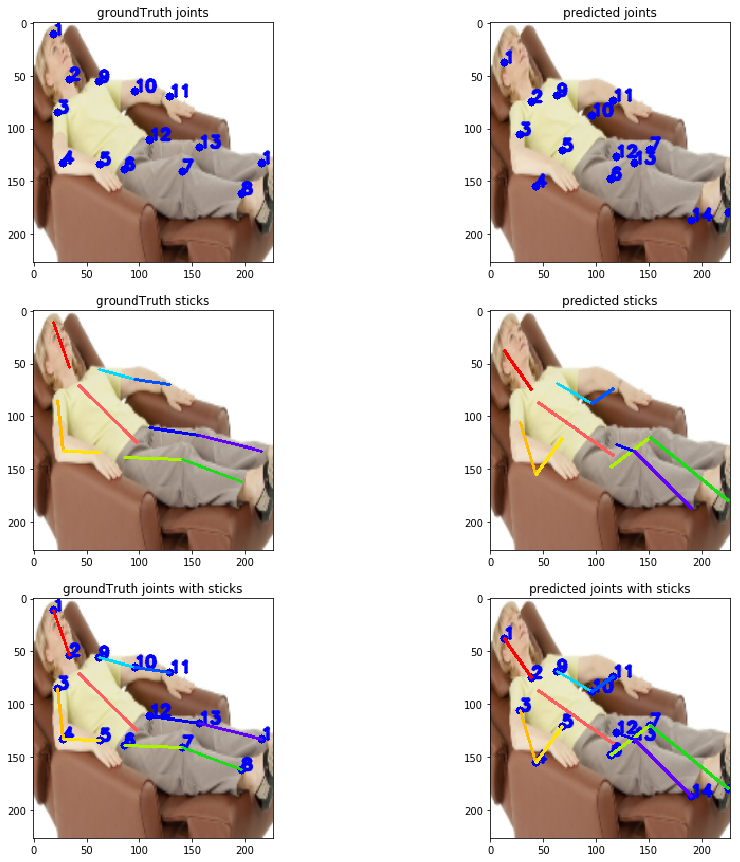

In [6]:
idx=395

orig_img1 = test_it.img_set[idx].copy()
orig_img2 = test_it.img_set[idx].copy()
orig_img3 = test_it.img_set[idx].copy()

pred_img1 = test_it.img_set[idx].copy()
pred_img2 = test_it.img_set[idx].copy()
pred_img3 = test_it.img_set[idx].copy()

orig_img1=tools.etc.markJoints(img=orig_img1, joints=orig_canonical[idx]['joints'])
orig_img2=tools.etc.drawSticks(img=orig_img2, sticks=orig_canonical[idx]['sticks'])

pred_img1=tools.etc.markJoints(img=pred_img1, joints=pred_canonical[idx]['joints'])
pred_img2=tools.etc.drawSticks(img=pred_img2, sticks=pred_canonical[idx]['sticks'])

orig_img3=tools.etc.markJoints(img=orig_img3, joints=orig_canonical[idx]['joints'])  
orig_img3=tools.etc.drawSticks(img=orig_img3, sticks=orig_canonical[idx]['sticks'])  

pred_img3=tools.etc.markJoints(img=pred_img3, joints=pred_canonical[idx]['joints'])
pred_img3=tools.etc.drawSticks(img=pred_img3, sticks=pred_canonical[idx]['sticks'])

fig, ((p11,p12),(p21,p22),(p31,p32),) = plt.subplots(3,2)
fig.set_size_inches(15, 15)

p11.set_title("groundTruth joints")
p11.imshow(orig_img1)
p12.set_title("predicted joints")
p12.imshow(pred_img1)

p21.set_title("groundTruth sticks")
p21.imshow(orig_img2)
p22.set_title("predicted sticks")
p22.imshow(pred_img2)

p31.set_title("groundTruth joints with sticks")
p31.imshow(orig_img3)
p32.set_title("predicted joints with sticks")
p32.imshow(pred_img3)